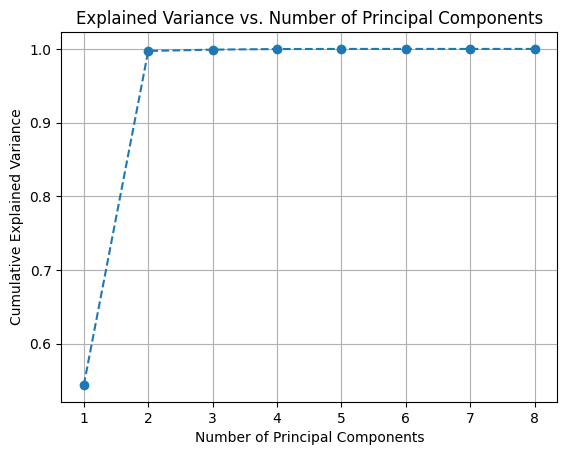

In [7]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the data from the CSV file
combined_FD_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_combined_FD.csv")

# Separate the data into X (features)
X = combined_FD_data.values

# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_standardized)

# Explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = explained_variance_ratios.cumsum()

# Plot explained variance ratios
plt.plot(range(1, len(explained_variance_ratios) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.grid()
plt.show()

# Choose the number of components to retain based on the plot
n_components = 2

# Apply PCA with the selected number of components
pca = PCA(n_components)
X_reduced = pca.fit_transform(X_standardized)

# Create a DataFrame from the PCA-transformed data
df_pca = pd.DataFrame(data=X_reduced)

# Define the path for the output CSV file
output_csv_file = "pca_transformed_data.csv"

# Save the DataFrame to a CSV file
df_pca.to_csv(output_csv_file, index=False)

Epoch [100/1000], Loss: 2419903.7500, Validation Loss: 2513609.0000
Epoch [200/1000], Loss: 782406.2500, Validation Loss: 792973.8125
Epoch [300/1000], Loss: 778575.6875, Validation Loss: 775086.5000
Epoch [400/1000], Loss: 776485.7500, Validation Loss: 772548.6250
Epoch [500/1000], Loss: 774496.1875, Validation Loss: 770021.1250
Epoch [600/1000], Loss: 772692.6250, Validation Loss: 767670.9375
Epoch [700/1000], Loss: 771124.6875, Validation Loss: 765562.3750
Epoch [800/1000], Loss: 769815.3750, Validation Loss: 763726.1875
Epoch [900/1000], Loss: 768765.5625, Validation Loss: 762171.5625
Epoch [1000/1000], Loss: 767958.7500, Validation Loss: 760894.6875
Clipped Predicted parameters:
[0.4864811301231384, 991.1851806640625, 0.0514100082218647, 0.5016633868217468, 968.5540771484375, 541.0698852539062, 500.37640380859375]


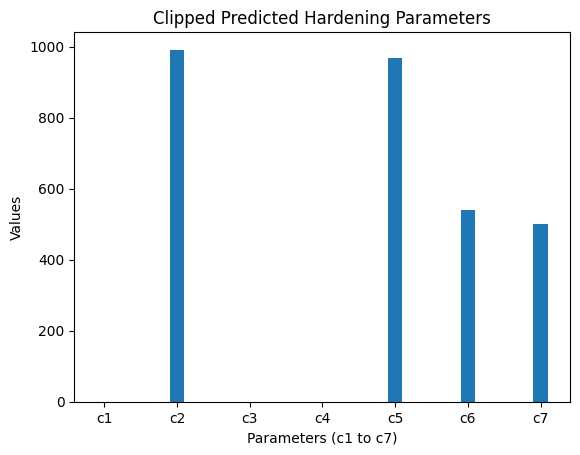

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load data from a single combined CSV file
combined_FD_file = "pca_transformed_data_x.csv"
combined_FD_data = pd.read_csv(combined_FD_file)

# Split the combined data into X (input) and Y (output) data
X_data = combined_FD_data.iloc[:, :2].values
Y_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv").values

# Normalize the input data
scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)

# Define a custom neural network model with L2 regularization
class ComplexNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, lambda_reg, lambda_reg_c6, lambda_reg_c7):
        super(ComplexNeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.LeakyReLU(negative_slope=0.01))
        
        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(nn.LeakyReLU(negative_slope=0.01))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        # Define the regularization strengths
        self.lambda_reg = lambda_reg
        self.lambda_reg_c6 = lambda_reg_c6
        self.lambda_reg_c7 = lambda_reg_c7

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def l2_regularization(self):
        l2_reg = 0.0
        for param in self.parameters():
            l2_reg += torch.norm(param) ** 2
        return l2_reg

# Define the L2 regularization strengths
lambda_reg = 0.0001
lambda_reg_c6 = 0.00001
lambda_reg_c7 = 0.00001

hidden_sizes = [128,64,32]
input_size = 2
output_size = 7

# Custom loss function with regularization and target parameter regularization
class CustomWeightedMSELoss(nn.Module):
    def __init__(self, lambda_reg=0.0, weight_c6=100.0, weight_c7=100.0, target_params=None):
        super(CustomWeightedMSELoss, self).__init__()
        self.lambda_reg = lambda_reg
        self.weight_c6 = weight_c6
        self.weight_c7 = weight_c7
        self.target_params = target_params

    def forward(self, outputs, targets):
        errors = outputs - targets
        squared_errors = errors ** 2

        # Calculate the weighted MSE loss
        weighted_mse_loss = torch.mean(squared_errors, dim=0)
        # Weight the loss for c6 and c7
        weighted_mse_loss[5] *= self.weight_c6
        weighted_mse_loss[6] *= self.weight_c7

        # Calculate L2 regularization
        reg_loss = 0.0
        for param in self.parameters():
            reg_loss += torch.norm(param) ** 2

        # Add regularization term to make the predicted parameters closer to the target parameters
        if self.target_params is not None:
            target_diff = (outputs - self.target_params) ** 2
            reg_loss += torch.mean(target_diff)

        return torch.sum(weighted_mse_loss) + self.lambda_reg * reg_loss

# Target parameters
target_params = torch.tensor([0.5, 1300, 0.000000000023, 0.075, 773.18, 1039.37, 73.94], dtype=torch.float32)

# Create an instance of the neural network
model = ComplexNeuralNetwork(input_size, hidden_sizes, output_size, lambda_reg, lambda_reg_c6, lambda_reg_c7)

# Define a loss function (custom MSE loss with L2 regularization and target parameter regularization)
criterion = CustomWeightedMSELoss(lambda_reg=lambda_reg, weight_c6=1.0, weight_c7=1.0, target_params=target_params)
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer with default learning rate

# Split the data into training and validation sets
num_samples = len(Y_data)
split_ratio = 0.8  
split_index = int(split_ratio * num_samples)

X_train = torch.tensor(X_data[:split_index], dtype=torch.float32)
Y_train = torch.tensor(Y_data[:split_index], dtype=torch.float32)
X_val = torch.tensor(X_data[split_index:], dtype=torch.float32)
Y_val = torch.tensor(Y_data[split_index:], dtype=torch.float32)

# Define early stopping parameters
patience = 20  # Number of consecutive epochs without improvement to tolerate
best_val_loss = float('inf')
no_improvement_count = 0

# Training loop with early stopping
num_epochs = 1000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)

    # Calculate the custom weighted MSE loss with regularization
    loss = criterion(outputs, Y_train)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation loss
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, Y_val)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
        # Save the model when validation loss improves
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch + 1} as validation loss did not improve for {patience} consecutive epochs.')
        break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Normalize the input data for prediction
X_test = torch.tensor(scaler.transform(X_data[:1]), dtype=torch.float32)

# Predict parameters
with torch.no_grad():
    predictions = model(X_test)

param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']

# Print the predicted parameters
print(f'Predicted parameters (nonclipped, with pca):') 
print(predictions[0].tolist())

# Visualize 'c1' to 'c7' values in a single graph
param_values = predictions[0].tolist()

plt.bar(np.arange(len(param_names)), param_values, width=0.2)
plt.xlabel('Parameters (c1 to c7)')
plt.ylabel('Values')
plt.title('Predicted Hardening Parameters with PCA')
plt.xticks(np.arange(len(param_names)), param_names)
plt.show()

Epoch [100/1000], Loss: 2800325.2500, Validation Loss: 2907910.0000
Epoch [200/1000], Loss: 809280.3750, Validation Loss: 848103.0625
Epoch [300/1000], Loss: 776080.3750, Validation Loss: 771002.8750
Epoch [400/1000], Loss: 774580.3750, Validation Loss: 770061.3750
Epoch [500/1000], Loss: 773239.3125, Validation Loss: 768328.1875
Epoch [600/1000], Loss: 771969.5000, Validation Loss: 766590.6250
Epoch [700/1000], Loss: 770810.0625, Validation Loss: 764952.9375
Epoch [800/1000], Loss: 769787.2500, Validation Loss: 763450.3750
Epoch [900/1000], Loss: 768912.9375, Validation Loss: 762108.2500
Epoch [1000/1000], Loss: 768188.2500, Validation Loss: 760936.1875
Clipped Predicted parameters with PCA:
[0.538629949092865, 1200.0, 0.0010000000474974513, 0.10000000149011612, 968.3947143554688, 1000.0, 100.0]


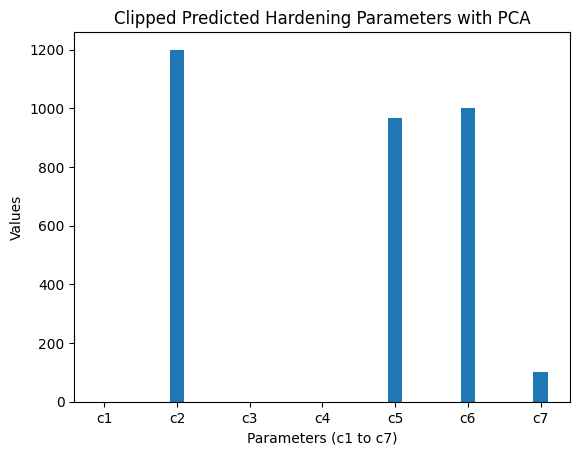

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load data from a single combined CSV file
combined_FD_file = "pca_transformed_data_x.csv"
combined_FD_data = pd.read_csv(combined_FD_file)
dropout_prob = 0.5

# Split the combined data into X (input) and Y (output) data
X_data = combined_FD_data.iloc[:, :2].values
Y_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv").values

# Normalize the input data
scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)

# Define a custom neural network model with L2 regularization
class ComplexNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, lambda_reg, lambda_reg_c6, lambda_reg_c7):
        super(ComplexNeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.LeakyReLU(negative_slope=0.01))
        
        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(nn.LeakyReLU(negative_slope=0.01))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        # Define the regularization strengths
        self.lambda_reg = lambda_reg
        self.lambda_reg_c6 = lambda_reg_c6
        self.lambda_reg_c7 = lambda_reg_c7

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def l2_regularization(self):
        l2_reg = 0.0
        for param in self.parameters():
            l2_reg += torch.norm(param) ** 2
        return l2_reg

# Define the L2 regularization strengths
lambda_reg = 0.0001
lambda_reg_c6 = 0.00001
lambda_reg_c7 = 0.00001

hidden_sizes = [128,64,32]
input_size = 2
output_size = 7

# Custom loss function with regularization and target parameter regularization
class CustomWeightedMSELoss(nn.Module):
    def __init__(self, lambda_reg=0.0, weight_c6=100.0, weight_c7=100.0, target_params=None):
        super(CustomWeightedMSELoss, self).__init__()
        self.lambda_reg = lambda_reg
        self.weight_c6 = weight_c6
        self.weight_c7 = weight_c7
        self.target_params = target_params

    def forward(self, outputs, targets):
        errors = outputs - targets
        squared_errors = errors ** 2

        # Calculate the weighted MSE loss
        weighted_mse_loss = torch.mean(squared_errors, dim=0)
        # Weight the loss for c6 and c7
        weighted_mse_loss[5] *= self.weight_c6
        weighted_mse_loss[6] *= self.weight_c7

        # Calculate L2 regularization
        reg_loss = 0.0
        for param in self.parameters():
            reg_loss += torch.norm(param) ** 2

        # Add regularization term to make the predicted parameters closer to the target parameters
        if self.target_params is not None:
            target_diff = (outputs - self.target_params) ** 2
            reg_loss += torch.mean(target_diff)

        return torch.sum(weighted_mse_loss) + self.lambda_reg * reg_loss

# Target parameters
target_params = torch.tensor([0.5, 1300, 0.000000000023, 0.075, 773.18, 1039.37, 73.94], dtype=torch.float32)

# Create an instance of the neural network
model = ComplexNeuralNetwork(input_size, hidden_sizes, output_size, lambda_reg, lambda_reg_c6, lambda_reg_c7)

# Define a loss function (custom MSE loss with L2 regularization and target parameter regularization)
criterion = CustomWeightedMSELoss(lambda_reg=lambda_reg, weight_c6=1.0, weight_c7=1.0, target_params=target_params)
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer with default learning rate

# Split the data into training and validation sets
num_samples = len(Y_data)
split_ratio = 0.8  
split_index = int(split_ratio * num_samples)

X_train = torch.tensor(X_data[:split_index], dtype=torch.float32)
Y_train = torch.tensor(Y_data[:split_index], dtype=torch.float32)
X_val = torch.tensor(X_data[split_index:], dtype=torch.float32)
Y_val = torch.tensor(Y_data[split_index:], dtype=torch.float32)

# Define early stopping parameters
patience = 20  # Number of consecutive epochs without improvement to tolerate
best_val_loss = float('inf')
no_improvement_count = 0

# Training loop with early stopping
num_epochs = 1000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)

    # Calculate the custom weighted MSE loss with regularization
    loss = criterion(outputs, Y_train)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation loss
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, Y_val)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
        # Save the model when validation loss improves
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch + 1} as validation loss did not improve for {patience} consecutive epochs.')
        break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Define the value ranges for each parameter
param_ranges = {
    'c1': (0.0, 1.0),
    'c2': (1200, 1500),
    'c3': (0.0, 0.001),
    'c4': (0.0, 0.1),
    'c5': (500, 1000),
    'c6': (1000, 1500),
    'c7': (0, 100)
 }

# Normalize the input data for prediction
X_test = torch.tensor(scaler.transform(X_data[:1]), dtype=torch.float32)

# Predict parameters
with torch.no_grad():
    predictions = model(X_test)

param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']

# Clip the predicted values to the specified ranges
for i, param_name in enumerate(param_names):
    min_val, max_val = param_ranges[param_name]
    predictions[0][i] = torch.clamp(predictions[0][i], min_val, max_val)

# Print the clipped predicted parameters
print(f'Clipped Predicted parameters with PCA:') 
print(predictions[0].tolist())

# Visualize clipped 'c1' to 'c7' values in a single graph
param_values = predictions[0].tolist()

plt.bar(np.arange(len(param_names)), param_values, width=0.2)
plt.xlabel('Parameters (c1 to c7)')
plt.ylabel('Values')
plt.title('Clipped Predicted Hardening Parameters with PCA')
plt.xticks(np.arange(len(param_names)), param_names)
plt.show()

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load data from a single combined CSV file
combined_FD_file = "pca_transformed_data_x.csv"
combined_FD_data = pd.read_csv(combined_FD_file)
dropout_prob = 0.5

# Split the combined data into X (input) and Y (output) data
X_data = combined_FD_data.iloc[:, :2].values
Y_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv").values

# Normalize the input data
scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)

# Define a custom neural network model with L2 regularization
class ComplexNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, lambda_reg, lambda_reg_c6, lambda_reg_c7):
        super(ComplexNeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.LeakyReLU(negative_slope=0.01))
        
        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(nn.LeakyReLU(negative_slope=0.01))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        # Define the regularization strengths
        self.lambda_reg = lambda_reg
        self.lambda_reg_c6 = lambda_reg_c6
        self.lambda_reg_c7 = lambda_reg_c7

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def l2_regularization(self):
        l2_reg = 0.0
        for param in self.parameters():
            l2_reg += torch.norm(param) ** 2
        return l2_reg

# Define the L2 regularization strengths
lambda_reg = 0.0001
lambda_reg_c6 = 0.00001
lambda_reg_c7 = 0.00001

hidden_sizes = [128,64,32]
input_size = 2
output_size = 7

# Custom loss function with regularization and target parameter regularization
class CustomWeightedMSELoss(nn.Module):
    def __init__(self, lambda_reg=0.0, weight_c6=100.0, weight_c7=100.0, target_params=None):
        super(CustomWeightedMSELoss, self).__init__()
        self.lambda_reg = lambda_reg
        self.weight_c6 = weight_c6
        self.weight_c7 = weight_c7
        self.target_params = target_params

    def forward(self, outputs, targets):
        errors = outputs - targets
        squared_errors = errors ** 2

        # Calculate the weighted MSE loss
        weighted_mse_loss = torch.mean(squared_errors, dim=0)
        # Weight the loss for c6 and c7
        weighted_mse_loss[5] *= self.weight_c6
        weighted_mse_loss[6] *= self.weight_c7

        # Calculate L2 regularization
        reg_loss = 0.0
        for param in self.parameters():
            reg_loss += torch.norm(param) ** 2

        # Add regularization term to make the predicted parameters closer to the target parameters
        if self.target_params is not None:
            target_diff = (outputs - self.target_params) ** 2
            reg_loss += torch.mean(target_diff)

        return torch.sum(weighted_mse_loss) + self.lambda_reg * reg_loss

# Target parameters
target_params = torch.tensor([0.5, 1300, 0.000000000023, 0.075, 773.18, 1039.37, 73.94], dtype=torch.float32)

# Create an instance of the neural network
model = ComplexNeuralNetwork(input_size, hidden_sizes, output_size, lambda_reg, lambda_reg_c6, lambda_reg_c7)

# Define a loss function (custom MSE loss with L2 regularization and target parameter regularization)
criterion = CustomWeightedMSELoss(lambda_reg=lambda_reg, weight_c6=1.0, weight_c7=1.0, target_params=target_params)
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer with default learning rate

# Split the data into training and validation sets
num_samples = len(Y_data)
split_ratio = 0.8  
split_index = int(split_ratio * num_samples)

X_train = torch.tensor(X_data[:split_index], dtype=torch.float32)
Y_train = torch.tensor(Y_data[:split_index], dtype=torch.float32)
X_val = torch.tensor(X_data[split_index:], dtype=torch.float32)
Y_val = torch.tensor(Y_data[split_index:], dtype=torch.float32)

# Define early stopping parameters
patience = 20  # Number of consecutive epochs without improvement to tolerate
best_val_loss = float('inf')
no_improvement_count = 0

# Training loop with early stopping
num_epochs = 1000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)

    # Calculate the custom weighted MSE loss with regularization
    loss = criterion(outputs, Y_train)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation loss
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, Y_val)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
        # Save the model when validation loss improves
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch + 1} as validation loss did not improve for {patience} consecutive epochs.')
        break

# Normalize the input data for prediction
X_test = torch.tensor(scaler.transform(X_data[:1]), dtype=torch.float32)

# Predict parameters
with torch.no_grad():
    predictions = model(X_test)

param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']

# Ideal values for c1 to c7
ideal_values = np.array([0.5, 1300, 2.3e-14, 0.075, 773.18, 1039.37, 73.94])


# Define the maximum deviation (10%)
max_deviation = 0.20

# Calculate the lower and upper bounds
lower_bounds = ideal_values - ideal_values * max_deviation
upper_bounds = ideal_values + ideal_values * max_deviation

# Ensure the predicted parameters are within the specified deviation range
predicted_params = predictions[0].numpy()
predicted_params = np.clip(predicted_params, lower_bounds, upper_bounds)

# Print the clipped predicted parameters and their bounds
param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
for i, param_name in enumerate(param_names):
    print(f'{param_name}: Predicted = {predicted_params[i]:.4f}')

Epoch [100/1000], Loss: 2708888.7500, Validation Loss: 2818915.0000
Epoch [200/1000], Loss: 797453.9375, Validation Loss: 836099.1875
Epoch [300/1000], Loss: 778593.5000, Validation Loss: 775035.6250
Epoch [400/1000], Loss: 776810.3125, Validation Loss: 773006.2500
Epoch [500/1000], Loss: 775043.7500, Validation Loss: 770744.3125
Epoch [600/1000], Loss: 773366.4375, Validation Loss: 768555.9375
Epoch [700/1000], Loss: 771827.0000, Validation Loss: 766524.0625
Epoch [800/1000], Loss: 770456.0625, Validation Loss: 764717.2500
Epoch [900/1000], Loss: 769247.1875, Validation Loss: 763298.5000
Epoch [1000/1000], Loss: 768219.8125, Validation Loss: 762128.6250
c1: Predicted = 0.4945
c2: Predicted = 991.3171
c3: Predicted = 0.0000
c4: Predicted = 0.1125
c5: Predicted = 968.0074
c6: Predicted = 541.3438
c7: Predicted = 110.9100


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load data from a single combined CSV file
combined_FD_file = "pca_transformed_data_x.csv"
combined_FD_data = pd.read_csv(combined_FD_file)
dropout_prob = 0.5

# Split the combined data into X (input) and Y (output) data
X_data = combined_FD_data.iloc[:, :2].values
Y_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv").values

# Normalize the input data
scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)

# Define a custom neural network model with L2 regularization
class ComplexNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, lambda_reg, lambda_reg_c6, lambda_reg_c7):
        super(ComplexNeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.LeakyReLU(negative_slope=0.01))
        
        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(nn.LeakyReLU(negative_slope=0.01))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        # Define the regularization strengths
        self.lambda_reg = lambda_reg
        self.lambda_reg_c6 = lambda_reg_c6
        self.lambda_reg_c7 = lambda_reg_c7

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def l2_regularization(self):
        l2_reg = 0.0
        for param in self.parameters():
            l2_reg += torch.norm(param) ** 2
        return l2_reg

# Define the L2 regularization strengths
lambda_reg = 0.0001
lambda_reg_c6 = 0.00001
lambda_reg_c7 = 0.00001

hidden_sizes = [128, 64, 32]
input_size = 2
output_size = 7

# Custom loss function with regularization
class CustomWeightedMSELoss(nn.Module):
    def __init__(self, lambda_reg=0.0):
        super(CustomWeightedMSELoss, self).__init__()
        self.lambda_reg = lambda_reg

    def forward(self, outputs, targets):
        errors = outputs - targets
        squared_errors = errors ** 2

        # Calculate the weighted MSE loss
        weighted_mse_loss = torch.mean(squared_errors, dim=0)

        # Calculate L2 regularization
        reg_loss = 0.0
        for param in self.parameters():
            reg_loss += torch.norm(param) ** 2

        return torch.sum(weighted_mse_loss) + self.lambda_reg * reg_loss

# Create an instance of the neural network
model = ComplexNeuralNetwork(input_size, hidden_sizes, output_size, lambda_reg, lambda_reg_c6, lambda_reg_c7)

# Define a loss function (custom MSE loss with L2 regularization)
criterion = CustomWeightedMSELoss(lambda_reg=lambda_reg)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with default learning rate

# Split the data into training and validation sets
num_samples = len(Y_data)
split_ratio = 0.8
split_index = int(split_ratio * num_samples)

X_train = torch.tensor(X_data[:split_index], dtype=torch.float32)
Y_train = torch.tensor(Y_data[:split_index], dtype=torch.float32)
X_val = torch.tensor(X_data[split_index:], dtype=torch.float32)
Y_val = torch.tensor(Y_data[split_index:], dtype=torch.float32)

# Define early stopping parameters
patience = 20  # Number of consecutive epochs without improvement to tolerate
best_val_loss = float('inf')
no_improvement_count = 0

# Training loop with early stopping
num_epochs = 1000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)

    # Calculate the custom weighted MSE loss with regularization
    loss = criterion(outputs, Y_train)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation loss
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, Y_val)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
        # Save the model when validation loss improves
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch + 1} as validation loss did not improve for {patience} consecutive epochs.')
        break

# Normalize the input data for prediction
X_test = torch.tensor(scaler.transform(X_data[:1]), dtype=torch.float32)

# Predict parameters
with torch.no_grad():
    predictions = model(X_test)

param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']

# Print the predicted parameters
predicted_params = predictions[0].numpy()
for i, param_name in enumerate(param_names):
    print(f'{param_name}: Predicted = {predicted_params[i]:.4f}')


Epoch [100/1000], Loss: 2543756.2500, Validation Loss: 2649263.2500
Epoch [200/1000], Loss: 781934.2500, Validation Loss: 800375.6250
Early stopping at epoch 291 as validation loss did not improve for 20 consecutive epochs.
c1: Predicted = 0.5313
c2: Predicted = 988.7163
c3: Predicted = -0.0255
c4: Predicted = 0.5176
c5: Predicted = 963.6702
c6: Predicted = 540.7383
c7: Predicted = 502.7495


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load data from a single combined CSV file
combined_FD_file = "pca_transformed_data_x.csv"
combined_FD_data = pd.read_csv(combined_FD_file)
dropout_prob = 0.5

# Split the combined data into X (input) and Y (output) data
X_data = combined_FD_data.iloc[:, :2].values
Y_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv").values

# Normalize the input data
scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)

# Define a custom neural network model with L2 regularization
class ComplexNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, lambda_reg):
        super(ComplexNeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.LeakyReLU(negative_slope=0.01))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            self.layers.append(nn.LeakyReLU(negative_slope=0.01))

        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

        # Define the regularization strength
        self.lambda_reg = lambda_reg

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def l2_regularization(self):
        l2_reg = 0.0
        for param in self.parameters():
            l2_reg += torch.norm(param) ** 2
        return l2_reg

# Define the L2 regularization strength
lambda_reg = 0.0001

hidden_sizes = [128, 64, 32]
input_size = 2
output_size = 7

# Custom loss function with regularization
class CustomWeightedMSELoss(nn.Module):
    def __init__(self, lambda_reg=0.0):
        super(CustomWeightedMSELoss, self).__init__()
        self.lambda_reg = lambda_reg

    def forward(self, outputs, targets):
        errors = outputs - targets
        squared_errors = errors ** 2

        # Calculate the mean squared error
        mse_loss = torch.mean(squared_errors, dim=0)

        # Calculate L2 regularization
        reg_loss = 0.0
        for param in self.parameters():
            reg_loss += torch.norm(param) ** 2

        return torch.sum(mse_loss) + self.lambda_reg * reg_loss

# Create an instance of the neural network
model = ComplexNeuralNetwork(input_size, hidden_sizes, output_size, lambda_reg)
criterion = CustomWeightedMSELoss(lambda_reg=lambda_reg)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with default learning rate

# Convert numpy arrays to torch tensors
X_train = torch.tensor(X_data[:split_index], dtype=torch.float32)
Y_train = torch.tensor(Y_data[:split_index], dtype=torch.float32)
X_val = torch.tensor(X_data[split_index:], dtype=torch.float32)
Y_val = torch.tensor(Y_data[split_index:], dtype=torch.float32)

# Define early stopping parameters
patience = 20  # Number of consecutive epochs without improvement to tolerate
best_val_loss = float('inf')
no_improvement_count = 0

# Training loop with early stopping
num_epochs = 1000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)

    # Calculate the custom weighted MSE loss with regularization
    loss = criterion(outputs, Y_train)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation loss
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, Y_val)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
        # Save the model when validation loss improves
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch + 1} as validation loss did not improve for {patience} consecutive epochs.')
        break

# Normalize the input data for prediction
X_test = torch.tensor(scaler.transform(X_data[:1]), dtype=torch.float32)

# Predict parameters
with torch.no_grad():
    predictions = model(X_test)

param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']

# Print the predicted parameters
predicted_params = predictions[0].numpy()
for i, param_name in enumerate(param_names):
    print(f'{param_name}: Predicted = {predicted_params[i]:.4f}')

Epoch [100/1000], Loss: 2597216.5000, Validation Loss: 2697056.0000
Epoch [200/1000], Loss: 795472.7500, Validation Loss: 809726.5000
Epoch [300/1000], Loss: 774306.3125, Validation Loss: 768861.8125
Epoch [400/1000], Loss: 772926.8750, Validation Loss: 767756.3125
Epoch [500/1000], Loss: 771688.3750, Validation Loss: 766083.2500
Epoch [600/1000], Loss: 770539.2500, Validation Loss: 764465.1875
Epoch [700/1000], Loss: 769518.7500, Validation Loss: 762971.5000
Epoch [800/1000], Loss: 768645.5000, Validation Loss: 761637.3125
Epoch [900/1000], Loss: 767927.1250, Validation Loss: 760481.1875
Epoch [1000/1000], Loss: 767358.8750, Validation Loss: 759508.9375
c1: Predicted = 0.4883
c2: Predicted = 990.7659
c3: Predicted = 0.0779
c4: Predicted = 0.5041
c5: Predicted = 968.9775
c6: Predicted = 540.6793
c7: Predicted = 499.6256


Epoch [100/1000], Loss: 2706747.0000, Validation Loss: 2817859.5000
Epoch [200/1000], Loss: 793455.1875, Validation Loss: 830508.5625
Epoch 00295: reducing learning rate of group 0 to 1.0000e-04.
Epoch [300/1000], Loss: 774515.1875, Validation Loss: 769721.8125
Epoch 00304: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00310: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00316: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00322: reducing learning rate of group 0 to 1.0000e-08.
Early stopping at epoch 332 as validation loss did not improve for 20 consecutive epochs.


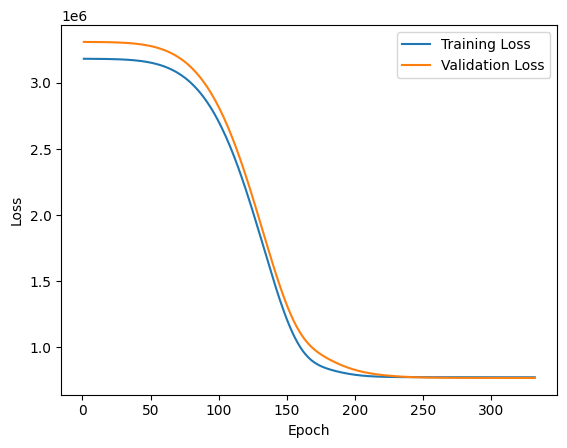

c1: Predicted = 0.5323
c2: Predicted = 990.2383
c3: Predicted = 0.0782
c4: Predicted = 0.5142
c5: Predicted = 964.4505
c6: Predicted = 541.3848
c7: Predicted = 503.4560


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load data from a single combined CSV file
combined_FD_file = "pca_transformed_data_x.csv"
combined_FD_data = pd.read_csv(combined_FD_file)

# Assuming split_index is defined
split_index = int(0.8 * len(combined_FD_data))  # Adjust as needed

# Split the combined data into X (input) and Y (output) data
X_data = combined_FD_data.iloc[:, :2].values
Y_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv").values

# Normalize the input data
scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)

# Define a custom neural network model with L2 regularization
class ComplexNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, lambda_reg):
        super(ComplexNeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.LeakyReLU(negative_slope=0.01))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            self.layers.append(nn.LeakyReLU(negative_slope=0.01))

        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

        # Define the regularization strength
        self.lambda_reg = lambda_reg

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def l2_regularization(self):
        l2_reg = 0.0
        for param in self.parameters():
            l2_reg += torch.norm(param) ** 2
        return l2_reg

# Define the L2 regularization strength
lambda_reg = 0.0001

hidden_sizes = [128, 64, 32]
input_size = 2
output_size = 7

# Custom loss function with regularization
class CustomWeightedMSELoss(nn.Module):
    def __init__(self, lambda_reg=0.0):
        super(CustomWeightedMSELoss, self).__init__()
        self.lambda_reg = lambda_reg

    def forward(self, outputs, targets):
        errors = outputs - targets
        squared_errors = errors ** 2

        # Calculate the mean squared error
        mse_loss = torch.mean(squared_errors, dim=0)

        # Calculate L2 regularization
        reg_loss = 0.0
        for param in self.parameters():
            reg_loss += torch.norm(param) ** 2

        return torch.sum(mse_loss) + self.lambda_reg * reg_loss

# Create an instance of the neural network
model = ComplexNeuralNetwork(input_size, hidden_sizes, output_size, lambda_reg)
criterion = CustomWeightedMSELoss(lambda_reg=lambda_reg)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Initial learning rate

# Convert numpy arrays to torch tensors
X_train = torch.tensor(X_data[:split_index], dtype=torch.float32)
Y_train = torch.tensor(Y_data[:split_index], dtype=torch.float32)
X_val = torch.tensor(X_data[split_index:], dtype=torch.float32)
Y_val = torch.tensor(Y_data[split_index:], dtype=torch.float32)

# Learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Define early stopping parameters
patience = 20  # Number of consecutive epochs without improvement to tolerate
best_val_loss = float('inf')
no_improvement_count = 0

# Lists to store the training and validation losses for plotting
train_losses = []
val_losses = []

# Training loop with early stopping and learning rate scheduling
num_epochs = 1000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)

    # Calculate the custom weighted MSE loss with regularization
    loss = criterion(outputs, Y_train)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation loss
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, Y_val)

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Append losses to the lists for later plotting
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
        # Save the model when validation loss improves
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch + 1} as validation loss did not improve for {patience} consecutive epochs.')
        break

# Normalize the input data for prediction
X_test = torch.tensor(scaler.transform(X_data[:1]), dtype=torch.float32)

# Predict parameters
with torch.no_grad():
    predictions = model(X_test)

param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']

# Print the predicted parameters
predicted_params = predictions[0].numpy()
for i, param_name in enumerate(param_names):
    print(f'{param_name}: Predicted = {predicted_params[i]:.4f}')

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load data from a single combined CSV file
combined_FD_file = "pca_transformed_data_x.csv"
combined_FD_data = pd.read_csv(combined_FD_file)

# Assuming split_index is defined
split_index = int(0.8 * len(combined_FD_data))  # Adjust as needed

# Split the combined data into X (input) and Y (output) data
X_data = combined_FD_data.iloc[:, :2].values
Y_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv").values

# Standardize the input data
scaler = StandardScaler()
X_data = scaler.fit_transform(X_data)

# Define a custom neural network model with L2 regularization
class ComplexNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, lambda_reg):
        super(ComplexNeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.LeakyReLU(negative_slope=0.01))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            self.layers.append(nn.LeakyReLU(negative_slope=0.01))

        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

        # Define the regularization strength
        self.lambda_reg = lambda_reg

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def l2_regularization(self):
        l2_reg = 0.0
        for param in self.parameters():
            l2_reg += torch.norm(param) ** 2
        return l2_reg

# Define the L2 regularization strength
lambda_reg = 0.0001

hidden_sizes = [64, 64, 64]
input_size = 2
output_size = 7

# Custom loss function with regularization
class CustomWeightedMSELoss(nn.Module):
    def __init__(self, lambda_reg=0.0):
        super(CustomWeightedMSELoss, self).__init__()
        self.lambda_reg = lambda_reg

    def forward(self, outputs, targets):
        errors = outputs - targets
        squared_errors = errors ** 2

        # Calculate the mean squared error
        mse_loss = torch.mean(squared_errors, dim=0)

        # Calculate L2 regularization
        reg_loss = 0.0
        for param in self.parameters():
            reg_loss += torch.norm(param) ** 2

        return torch.sum(mse_loss) + self.lambda_reg * reg_loss

# Create an instance of the neural network
model = ComplexNeuralNetwork(input_size, hidden_sizes, output_size, lambda_reg)
criterion = CustomWeightedMSELoss(lambda_reg=lambda_reg)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Initial learning rate

# Convert numpy arrays to torch tensors
X_train = torch.tensor(X_data[:split_index], dtype=torch.float32)
Y_train = torch.tensor(Y_data[:split_index], dtype=torch.float32)
X_val = torch.tensor(X_data[split_index:], dtype=torch.float32)
Y_val = torch.tensor(Y_data[split_index:], dtype=torch.float32)

# Learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Define early stopping parameters
patience = 20  # Number of consecutive epochs without improvement to tolerate
best_val_loss = float('inf')
no_improvement_count = 0

# Lists to store the training and validation losses for plotting
train_losses = []
val_losses = []

# Training loop with early stopping and learning rate scheduling
num_epochs = 1000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)

    # Calculate the custom weighted MSE loss with regularization
    loss = criterion(outputs, Y_train)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation loss
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, Y_val)

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Append losses to the lists for later plotting
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
        # Save the model when validation loss improves
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch + 1} as validation loss did not improve for {patience} consecutive epochs.')
        break

# Normalize the input data for prediction
X_test = torch.tensor(scaler.transform(X_data[:1]), dtype=torch.float32)

# Predict parameters
with torch.no_grad():
    predictions = model(X_test)

param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']

# Print the predicted parameters 
predicted_params = predictions[0].numpy()
for i, param_name in enumerate(param_names):
    print(f'{param_name}: Predicted = {predicted_params[i]:.4f}')


Epoch [100/1000], Loss: 2444084.5000, Validation Loss: 2576481.5000
Epoch [200/1000], Loss: 850855.9375, Validation Loss: 971287.3125
Epoch [300/1000], Loss: 802465.5625, Validation Loss: 869445.1875
Epoch [400/1000], Loss: 777625.1250, Validation Loss: 818790.0625
Epoch [500/1000], Loss: 763787.0000, Validation Loss: 785694.2500
Epoch [600/1000], Loss: 755675.3750, Validation Loss: 763645.9375
Epoch [700/1000], Loss: 750230.6875, Validation Loss: 751645.6875
Epoch [800/1000], Loss: 744007.5625, Validation Loss: 746309.4375
Epoch 00854: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00860: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00866: reducing learning rate of group 0 to 1.0000e-06.
Early stopping at epoch 869 as validation loss did not improve for 20 consecutive epochs.
c1: Predicted = 0.5233
c2: Predicted = 777.5833
c3: Predicted = 0.0142
c4: Predicted = 0.4941
c5: Predicted = 751.3911
c6: Predicted = 437.4249
c7: Predicted = 417.8813


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load data from a single combined CSV file
combined_FD_file = "pca_transformed_data_x.csv"
combined_FD_data = pd.read_csv(combined_FD_file)

# Assuming split_index is defined
split_index = int(0.8 * len(combined_FD_data))  # Adjust as needed

# Split the combined data into X (input) and Y (output) data
X_data = combined_FD_data.iloc[:, :2].values
Y_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv").values

# Standardize the input data
scaler_x = StandardScaler()
X_data = scaler_x.fit_transform(X_data)

# Standardize the target data
scaler_y = StandardScaler()
Y_data = scaler_y.fit_transform(Y_data)

# Define a custom neural network model with L2 regularization
class ComplexNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, lambda_reg):
        super(ComplexNeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.LeakyReLU(negative_slope=0.01))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            self.layers.append(nn.LeakyReLU(negative_slope=0.01))

        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

        # Define the regularization strength
        self.lambda_reg = lambda_reg

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def l2_regularization(self):
        l2_reg = 0.0
        for param in self.parameters():
            l2_reg += torch.norm(param) ** 2
        return l2_reg

# Define the L2 regularization strength
lambda_reg = 0.0001
hidden_sizes = [64, 64, 64]
input_size = 2
output_size = 7

# Custom loss function with regularization
class CustomWeightedMSELoss(nn.Module):
    def __init__(self, lambda_reg):
        super(CustomWeightedMSELoss, self).__init__()
        self.lambda_reg = lambda_reg

    def forward(self, outputs, targets):
        errors = outputs - targets
        squared_errors = errors ** 2

        # Calculate the mean squared error
        mse_loss = torch.mean(squared_errors, dim=0)

        # Calculate L2 regularization
        reg_loss = 0.0
        for param in self.parameters():
            reg_loss += torch.norm(param) ** 2

        return torch.sum(mse_loss) + self.lambda_reg * reg_loss

# Create an instance of the neural network
model = ComplexNeuralNetwork(input_size, hidden_sizes, output_size, lambda_reg)
criterion = CustomWeightedMSELoss(lambda_reg=lambda_reg)
optimizer = optim.Adam(model.parameters(), lr=0.00001)  # Initial learning rate

# Convert numpy arrays to torch tensors
X_train = torch.tensor(X_data[:split_index], dtype=torch.float32)
Y_train = torch.tensor(Y_data[:split_index], dtype=torch.float32)
X_val = torch.tensor(X_data[split_index:], dtype=torch.float32)
Y_val = torch.tensor(Y_data[split_index:], dtype=torch.float32)

# Learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Define early stopping parameters
patience = 20  # Number of consecutive epochs without improvement to tolerate
best_val_loss = float('inf')
no_improvement_count = 0

# Lists to store the training and validation losses for plotting
train_losses = []
val_losses = []

# Training loop with early stopping and learning rate scheduling
num_epochs = 1000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)

    # Calculate the custom weighted MSE loss with regularization
    loss = criterion(outputs, Y_train)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation loss
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, Y_val)

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Append losses to the lists for later plotting
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
        # Save the model when validation loss improves
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch + 1} as validation loss did not improve for {patience} consecutive epochs.')
        break

# Normalize the input data for prediction
X_test = torch.tensor(scaler_x.transform(X_data[:1]), dtype=torch.float32)

# Ensure that X_test has 2D shape
X_test = X_test.view(1, -1)

# Predict parameters
with torch.no_grad():
    predictions = model(X_test)

# Denormalize the predicted parameters
predicted_params = scaler_y.inverse_transform(predictions.numpy())

param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']

# Print the denormalized predicted parameters
for i, param_name in enumerate(param_names):
    print(f'{param_name}: Predicted = {predicted_params[0][i]:.4f}')



Epoch [100/1000], Loss: 7.1988, Validation Loss: 6.4225
Epoch [200/1000], Loss: 7.1545, Validation Loss: 6.3912
Epoch [300/1000], Loss: 7.1127, Validation Loss: 6.3594
Epoch [400/1000], Loss: 7.0705, Validation Loss: 6.3256
Epoch [500/1000], Loss: 7.0255, Validation Loss: 6.2892
Epoch [600/1000], Loss: 6.9786, Validation Loss: 6.2492
Epoch [700/1000], Loss: 6.9302, Validation Loss: 6.2064
Epoch [800/1000], Loss: 6.8802, Validation Loss: 6.1615
Epoch [900/1000], Loss: 6.8281, Validation Loss: 6.1143
Epoch [1000/1000], Loss: 6.7743, Validation Loss: 6.0688
c1: Predicted = 0.5572
c2: Predicted = 930.4323
c3: Predicted = 0.0504
c4: Predicted = 0.5483
c5: Predicted = 865.1840
c6: Predicted = 524.2387
c7: Predicted = 485.1558


In [26]:
# Function to calculate feature importance
def calculate_feature_importance(model, data, target):
    model.eval()
    data = torch.tensor(data, dtype=torch.float32, requires_grad=True)

    # Forward pass
    outputs = model(data)

    # Calculate loss
    loss = criterion(outputs, torch.tensor(target, dtype=torch.float32))

    # Backward pass to get gradients
    loss.backward()

    # Calculate feature importance as the absolute mean of the gradients
    feature_importance = torch.abs(data.grad).mean(dim=0).detach().numpy()

    return feature_importance

# Calculate feature importance for X_train
feature_importance = calculate_feature_importance(model, X_train, Y_train)

# Print feature importance
print("Feature Importance:")
for i, importance in enumerate(feature_importance):
    print(f"Feature {i+1}: {importance:.4f}")


Feature Importance:
Feature 1: 0.0000
Feature 2: 0.0000


/var/folders/l7/8xg0btt51d942x_m3f7qw46r0000gn/T/ipykernel_68867/1966357309.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32, requires_grad=True)
/var/folders/l7/8xg0btt51d942x_m3f7qw46r0000gn/T/ipykernel_68867/1966357309.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(target, dtype=torch.float32))


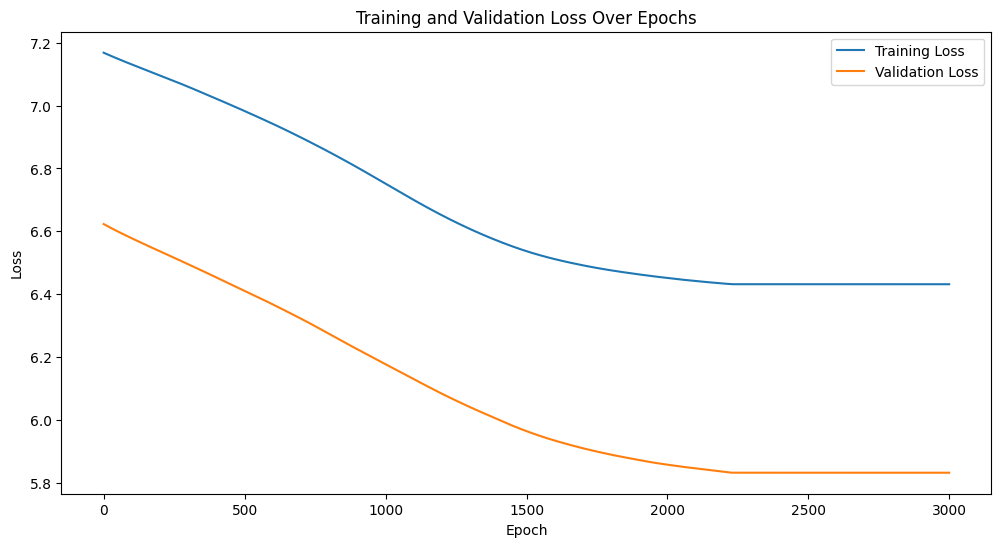

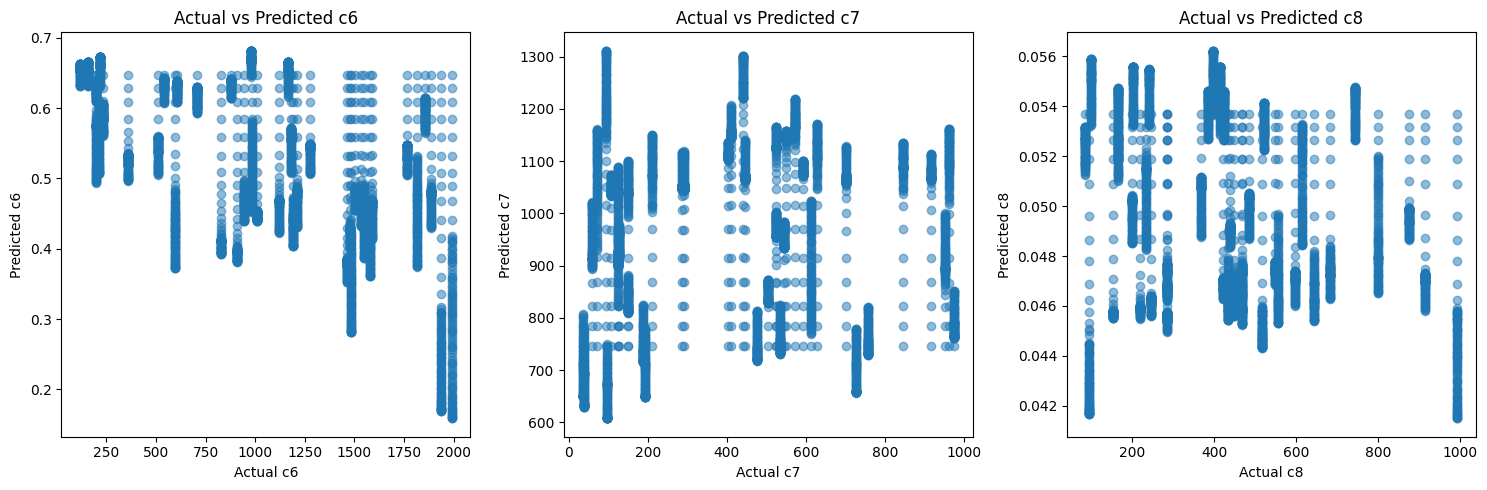

In [27]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Visualize actual vs. predicted values for c6, c6, and c7
model.eval()
with torch.no_grad():
    predictions = model(X_val)

# Denormalize the predicted parameters
predicted_params = scaler_y.inverse_transform(predictions.numpy())

# Select c6, c6, and c7 columns
c6_c7_actual = scaler_y.inverse_transform(Y_val.numpy())[:, 4:7]  # Assuming columns 4, 5, and 6 are c6, c6, and c7

# Plot actual vs. predicted values
plt.figure(figsize=(15, 5))
for i in range(3):  # Loop for c6, c6, and c7
    plt.subplot(1, 3, i + 1)
    plt.scatter(c6_c7_actual[:, i], predicted_params[:, i], alpha=0.5)
    plt.xlabel(f'Actual c{i+6}')
    plt.ylabel(f'Predicted c{i+6}')
    plt.title(f'Actual vs Predicted c{i+6}')

plt.tight_layout()
plt.show()

In [28]:
# Print ranges of original and denormalized data
print("Original Range of c6:", np.min(Y_data[:, 5]), np.max(Y_data[:, 5]))
print("Denormalized Range of Predicted c6:", np.min(predicted_params[:, 2]), np.max(predicted_params[:, 2]))

Original Range of c6: -1.7302435538759582 1.6436564100606668
Denormalized Range of Predicted c6: 0.041494653 0.05622838


Epoch [100/1000], Loss: 7.1252, Validation Loss: 6.3529
Epoch [200/1000], Loss: 7.0730, Validation Loss: 6.3277
Epoch [300/1000], Loss: 7.0183, Validation Loss: 6.2959
Epoch [400/1000], Loss: 6.9590, Validation Loss: 6.2596
Epoch [500/1000], Loss: 6.8984, Validation Loss: 6.2231
Epoch [600/1000], Loss: 6.8379, Validation Loss: 6.1873
Epoch [700/1000], Loss: 6.7783, Validation Loss: 6.1506
Epoch [800/1000], Loss: 6.7219, Validation Loss: 6.1143
Epoch [900/1000], Loss: 6.6707, Validation Loss: 6.0790
Epoch [1000/1000], Loss: 6.6250, Validation Loss: 6.0447
Mean of scaler_y: [5.34658466e-01 9.78052805e+02 4.97201720e-02 5.16963196e-01
 9.46767677e+02 5.11549655e+02 4.90944094e+02]
Scale of scaler_y: [2.77738711e-01 5.78060315e+02 3.06421407e-02 2.80256060e-01
 5.87929101e+02 2.94495797e+02 2.92233749e+02]
Original Range of c6: -1.6042194797640013 1.7200452255249026
Denormalized Range of Predicted c6: 0.27936664 0.5748351
Data Type of Y_data: float64
Data Type of Predicted c6: float32
c1: 

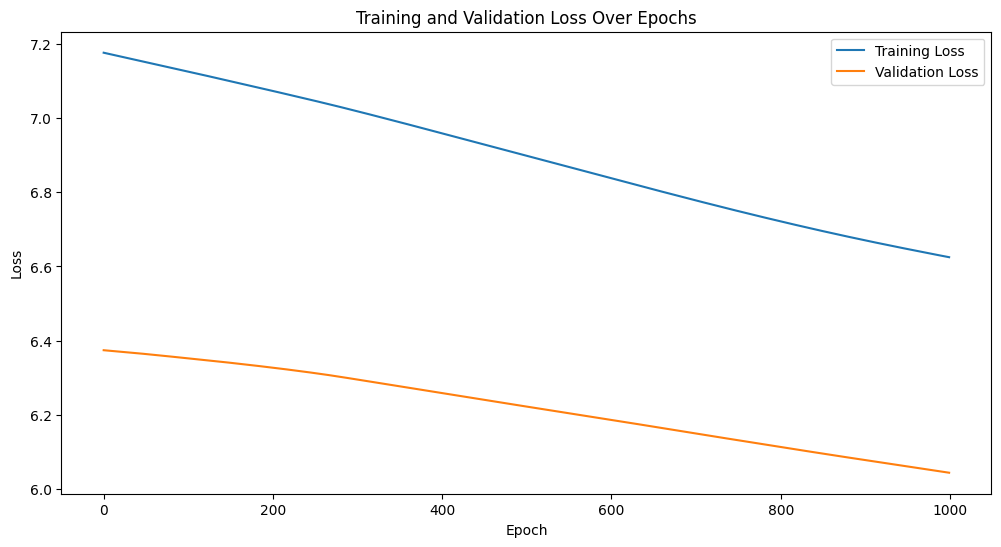

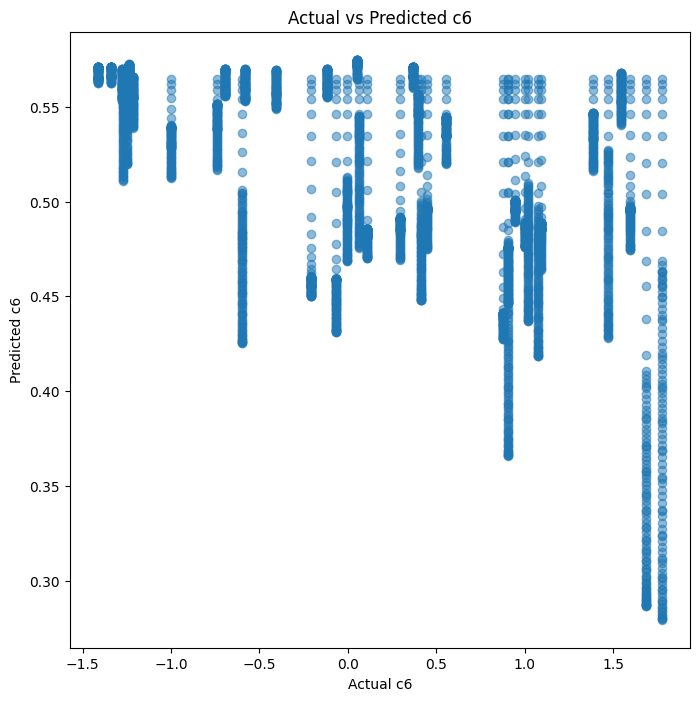

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load data from a single combined CSV file
combined_FD_file = "pca_transformed_data_x.csv"
combined_FD_data = pd.read_csv(combined_FD_file)

# Assuming split_index is defined
split_index = int(0.8 * len(combined_FD_data))  # Adjust as needed

# Split the combined data into X (input) and Y (output) data
X_data = combined_FD_data.iloc[:, :2].values
Y_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv").values

# Standardize the input data
scaler_x = StandardScaler()
X_data = scaler_x.fit_transform(X_data)

# Standardize the target data
scaler_y = StandardScaler()
Y_data = scaler_y.fit_transform(Y_data)

# Define a custom neural network model with L2 regularization
class ComplexNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, lambda_reg):
        super(ComplexNeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.LeakyReLU(negative_slope=0.01))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            self.layers.append(nn.LeakyReLU(negative_slope=0.01))

        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

        # Define the regularization strength
        self.lambda_reg = lambda_reg

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def l2_regularization(self):
        l2_reg = 0.0
        for param in self.parameters():
            l2_reg += torch.norm(param) ** 2
        return l2_reg

# Define the L2 regularization strength
lambda_reg = 0.0001
hidden_sizes = [64, 64, 64]
input_size = 2
output_size = 7

# Custom loss function with regularization
class CustomWeightedMSELoss(nn.Module):
    def __init__(self, lambda_reg):
        super(CustomWeightedMSELoss, self).__init__()
        self.lambda_reg = lambda_reg

    def forward(self, outputs, targets):
        errors = outputs - targets
        squared_errors = errors ** 2

        # Calculate the mean squared error
        mse_loss = torch.mean(squared_errors, dim=0)

        # Calculate L2 regularization
        reg_loss = 0.0
        for param in self.parameters():
            reg_loss += torch.norm(param) ** 2

        return torch.sum(mse_loss) + self.lambda_reg * reg_loss

# Create an instance of the neural network
model = ComplexNeuralNetwork(input_size, hidden_sizes, output_size, lambda_reg)
criterion = CustomWeightedMSELoss(lambda_reg=lambda_reg)
optimizer = optim.Adam(model.parameters(), lr=0.00001)  # Initial learning rate

# Convert numpy arrays to torch tensors
X_train = torch.tensor(X_data[:split_index], dtype=torch.float32)
Y_train = torch.tensor(Y_data[:split_index], dtype=torch.float32)
X_val = torch.tensor(X_data[split_index:], dtype=torch.float32)
Y_val = torch.tensor(Y_data[split_index:], dtype=torch.float32)

# Learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Define early stopping parameters
patience = 20  # Number of consecutive epochs without improvement to tolerate
best_val_loss = float('inf')
no_improvement_count = 0

# Lists to store the training and validation losses for plotting
train_losses = []
val_losses = []

# Training loop with early stopping and learning rate scheduling
num_epochs = 1000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)

    # Calculate the custom weighted MSE loss with regularization
    loss = criterion(outputs, Y_train)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation loss
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, Y_val)

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Append losses to the lists for later plotting
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0

        # Save the model when validation loss improves
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch + 1} as validation loss did not improve for {patience} consecutive epochs.')
        break

# Verify Denormalization Parameters
print("Mean of scaler_y:", scaler_y.mean_)
print("Scale of scaler_y:", scaler_y.scale_)

# Denormalize the predicted parameters with explicit data type conversion
with torch.no_grad():
    predictions = model(X_val)

# Ensure predicted_params has the same shape as Y_val
predicted_params = scaler_y.inverse_transform(predictions.numpy()).astype(np.float32)  # Convert to float32

# Print ranges of original and denormalized data
print("Original Range of c6:", np.min(Y_data[:, 4]), np.max(Y_data[:, 6]))
print("Denormalized Range of Predicted c6:", np.min(predicted_params[:, 0]), np.max(predicted_params[:, 0]))

# Print data types of original and denormalized data
print("Data Type of Y_data:", Y_data[:, 4].dtype)
print("Data Type of Predicted c6:", predicted_params[:, 0].dtype)

# Print the denormalized predicted parameters for c1 to c7
param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']

# Print the denormalized predicted parameters
for i, param_name in enumerate(param_names):
    print(f'{param_name}: Predicted = {predicted_params[0][i]:.4f}')

# Visualize actual vs. predicted values for c6
plt.figure(figsize=(8, 8))
plt.scatter(Y_val[:, 4], predicted_params[:, 0], alpha=0.5)
plt.xlabel('Actual c6')
plt.ylabel('Predicted c6')
plt.title('Actual vs Predicted c6')
plt.show()


In [34]:
# Print mean and scale parameters used during training
print("Mean during training:", scaler_y.mean_)
print("Scale during training:", scaler_y.scale_)

# ... (your existing code)

# Print mean and scale parameters used during prediction
print("Mean during prediction:", scaler_y.mean_)
print("Scale during prediction:", scaler_y.scale_)

print(model)

Mean during training: [5.34658466e-01 9.78052805e+02 4.97201720e-02 5.16963196e-01
 9.46767677e+02 5.11549655e+02 4.90944094e+02]
Scale during training: [2.77738711e-01 5.78060315e+02 3.06421407e-02 2.80256060e-01
 5.87929101e+02 2.94495797e+02 2.92233749e+02]
Mean during prediction: [5.34658466e-01 9.78052805e+02 4.97201720e-02 5.16963196e-01
 9.46767677e+02 5.11549655e+02 4.90944094e+02]
Scale during prediction: [2.77738711e-01 5.78060315e+02 3.06421407e-02 2.80256060e-01
 5.87929101e+02 2.94495797e+02 2.92233749e+02]
ComplexNeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=64, out_features=7, bias=True)
  )
)
